In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0"])

SCOL = "20000_90"
stormsDf[SCOL + "_storm"] = True

merged = pd.merge(artDf, stormsDf.drop(columns=[SCOL]), on="key", how="left")

#important: remove any dates before our first local date 
merged = merged[merged["date"] >= "2020-04-01"]


<ipython-input-3-d15d318dab54>:5: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [13]:
#shouldn't have filtered on string up above but it did the job 
merged["date"] = pd.to_datetime(merged["date"])

In [14]:
#get each date as a date since the first story in our data 
#get the first date in our dataset 
minDate = min(merged["date"])

merged["dateInt"] = merged["date"].apply(lambda x: (x - minDate) / np.timedelta64(1, "D"))

In [18]:
SCOL = "20000_90"

In [20]:
#get largest stories 
sClustDf = merged[["source", SCOL, "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby(SCOL).agg(list).reset_index()
sClustDf["clustSize"] = sClustDf["key"].apply(len)
sClustDf["nationalPercent"] = sClustDf["national"].apply(np.mean)
sClustDf["duration"] = ((sClustDf["date"].apply(max) - sClustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
sClustDf["numStates"] = sClustDf["state"].apply(getUnique)

In [388]:
#get largest stories 
clustDf = df[["source", "clustNum", "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby("clustNum").agg(list).reset_index()
clustDf["clustSize"] = clustDf["key"].apply(len)
clustDf["nationalPercent"] = clustDf["national"].apply(np.mean)
clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
clustDf["numStates"] = clustDf["state"].apply(getUnique)

In [390]:
#get variance of our date integer 
clustDf["dateStd"] = clustDf["dateInt"].apply(np.std) 

In [108]:
#consideration: maybe make a cutoff using the variance of news story duration? 

In [ ]:
#political unrest in Belarus 
#nashville bombing 
#couple pointing guns at protestors 

In [33]:
#get the top stories in long format so we can plot their times series 
def generateTopStories(clustDf, topStoryNum, sortCol): 
    
    #typically sortCol will be "clustSize", but can also be spike size or something else 
    #get top number of stories for this column 
    topStories = clustDf.sort_values(sortCol, ascending=False).head(topStoryNum)

    #return the date ints that has the highest frequency in the inList of date ints 
    def maxDateInt(inList): 
        return Counter(inList).most_common()[0][0]

    #this will be used to sort stories by their peaks 
    topStories["topDay"] = topStories["dateInt"].apply(maxDateInt)

    def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
    #explode stories out from the story level, then group back again at the story,day level 
    topStories = topStories.explode(["source", "national", "key", "content", "title", "date", "dateInt", "lat", "lon", "state"])
    topStoriesDaily = topStories[[SCOL, "dateInt", "key", "topDay", "lat", "lon", "state"]].groupby([SCOL, "dateInt"])\
    .agg({"key":len, "topDay":list, "state":getUnique, "lat":list, "lon":list}).reset_index()

    topStoriesDaily["topDay"] = topStoriesDaily["topDay"].apply(lambda x: x[0])
    
    return topStoriesDaily 


In [88]:
def plotTopStories(topStoriesDaily,  savePath): 
    outTups = []
    fig, ax = plt.subplots(figsize=(12, 3.5))
    palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
    for i, clustNum in enumerate(topStoriesDaily.sort_values("topDay", ascending=True)[SCOL].unique()): 
        currColor = palette[i % len(palette)]
        currStories = topStoriesDaily[topStoriesDaily[SCOL] == clustNum] #.drop(columns=["key"])

        #get the day ints that we need to fill in
        lastDay = max(merged["dateInt"])
        missingDays = set(range(0, int(lastDay))) - set(currStories["dateInt"].unique())

        #a dataframe to fill in missing days with 0 stories 
        topDay = list(currStories["topDay"])[0]
        missingDaysDf = pd.DataFrame({SCOL:clustNum, "dateInt":list(missingDays), "key":0, "topDay":topDay})
        currStories = pd.concat([currStories, missingDaysDf], axis=0).sort_values("dateInt")

        ax.plot(currStories["dateInt"], currStories["key"], color=currColor)
        #seaborn version: (same) plot = sns.lineplot(x="dateInt",y="key",data=currStories, alpha=1)
        ax.fill_between(currStories.dateInt.values, currStories.key.values, zorder=i, color=currColor)
        outTups.append((clustNum, currColor, topDay))
        
    ax.set_title(f"Media Storms: April 1, 2020 - December 31, 2021")
    ax.set_xlabel("day since April 1")
    ax.set_ylabel("# of articles")
    ax.set_xlim(0, lastDay)
    plt.savefig(savePath, bbox_inches="tight")
    plt.show()
    return outTups

In [89]:
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = ["#008837", "#7b3294"]

In [90]:
numStorms = len(stormsDf[SCOL].unique())
numStorms

98

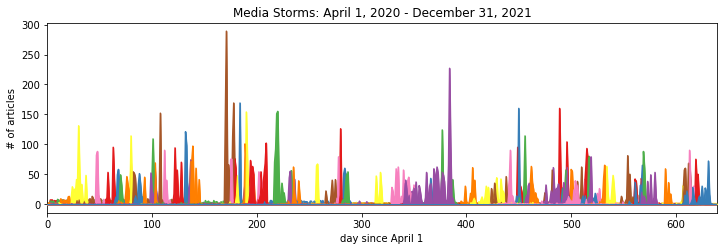

In [91]:
#first, look at all storms 
topStoriesDaily = generateTopStories(sClustDf, numStorms, "clustSize")
outTups = plotTopStories(topStoriesDaily, savePath = FIG_PATH + "allStormsSeries.pdf")

In [92]:
outTups

[(47785.0, '#e41a1c', 3.0),
 (301245.0, '#377eb8', 5.0),
 (43349.0, '#4daf4a', 10.0),
 (119353.0, '#984ea3', 15.0),
 (11934.0, '#ff7f00', 21.0),
 (14119.0, '#ffff33', 30.0),
 (182492.0, '#a65628', 43.0),
 (2864.0, '#f781bf', 48.0),
 (33116.0, '#e41a1c', 63.0),
 (33543.0, '#377eb8', 68.0),
 (16713.0, '#4daf4a', 70.0),
 (119453.0, '#984ea3', 77.0),
 (2965.0, '#ff7f00', 80.0),
 (16790.0, '#ffff33', 80.0),
 (25227.0, '#a65628', 82.0),
 (386788.0, '#f781bf', 83.0),
 (25981.0, '#e41a1c', 85.0),
 (3016.0, '#377eb8', 88.0),
 (3075.0, '#4daf4a', 101.0),
 (118121.0, '#984ea3', 103.0),
 (3034.0, '#ff7f00', 103.0),
 (119271.0, '#ffff33', 108.0),
 (3099.0, '#a65628', 108.0),
 (20189.0, '#f781bf', 112.0),
 (3156.0, '#e41a1c', 122.0),
 (3216.0, '#377eb8', 132.0),
 (92210.0, '#4daf4a', 134.0),
 (20292.0, '#984ea3', 137.0),
 (3233.0, '#ff7f00', 139.0),
 (267184.0, '#ffff33', 161.0),
 (533.0, '#a65628', 171.0),
 (20469.0, '#f781bf', 176.0),
 (3380.0, '#e41a1c', 179.0),
 (17567.0, '#377eb8', 184.0),
 (11

In [94]:
list(merged[merged["clustNum"] == 533].sample(10)["title"])

KeyError: 'clustNum'

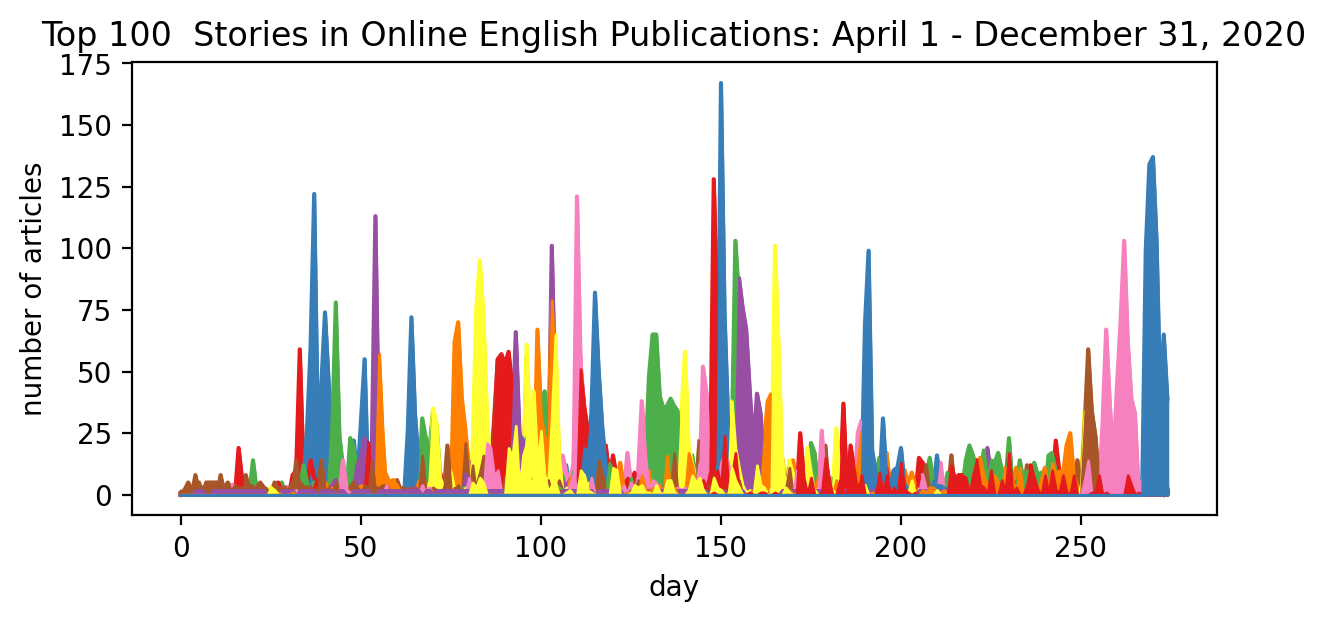

In [514]:
#first, look at the top 50 stories in general 
topStoriesDaily = generateTopStories(clustDf, 50, "clustSize")
allStories = plotTopStories(topStoriesDaily, "")

In [502]:
list(df[df["clustNum"] == 19927.0].sample(10)["title"])

['Ahmaud Arbery killing: Man who filmed shooting is arrested on suspicion of murder',
 'Arrests made in shooting death of black man after outcry',
 'Arrests Made in Shooting Death of Ahmaud Arbery',
 'Ahmaud Arbery shooting: Three men indicted on murder charges over death of jogger',
 '911 call, text hint at confrontation days before Arbery shot...',
 'Hundreds Demand Justice For Ahmaud Arbery At Georgia Rally',
 'Who was Ahmaud Arbery? The timeline of events in the tragic case',
 'Judge to weigh bond for father, son in Ahmaud Arbery slaying',
 'Judge rules there is enough evidence to try 3 men for murder of Ahmaud Arbery',
 'Arbery family lawyer: Feds looking into how case handled']

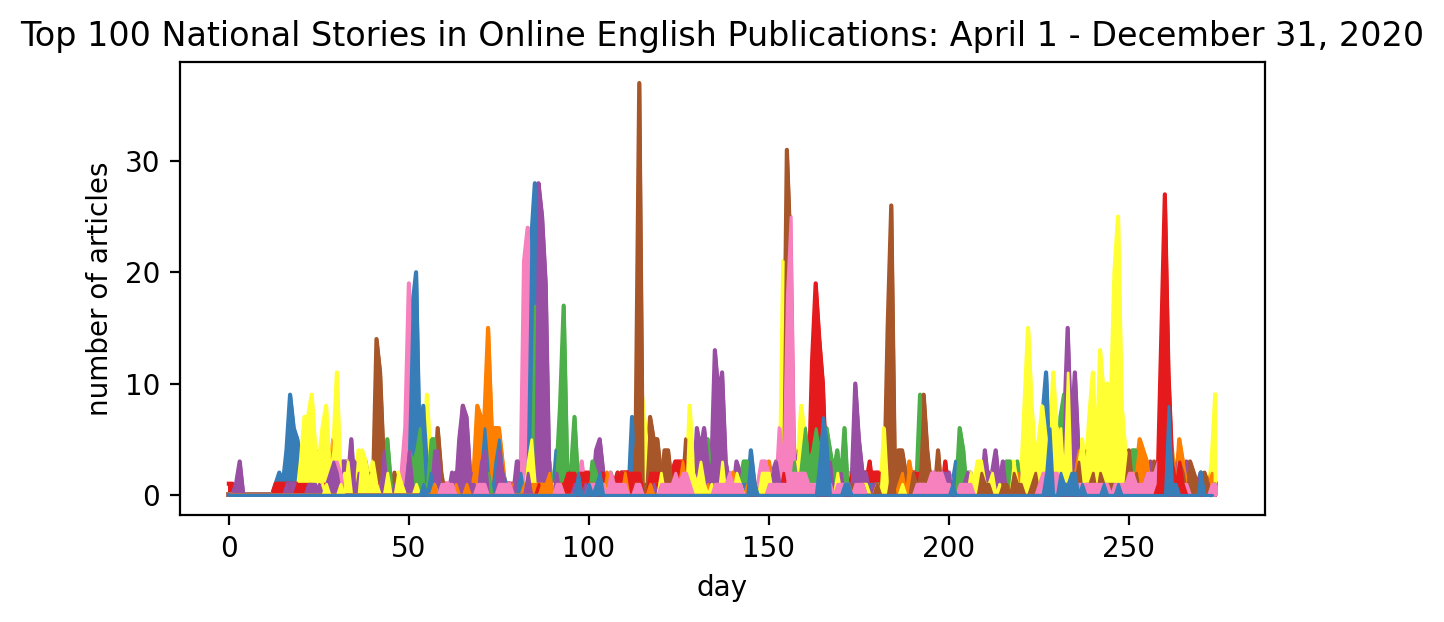

In [515]:
#look at only national stories 
nationalDf = clustDf[clustDf["nationalPercent"] == 1]
topNatStories = generateTopStories(nationalDf, 50, "clustSize")
natStories = plotTopStories(topNatStories, "National")

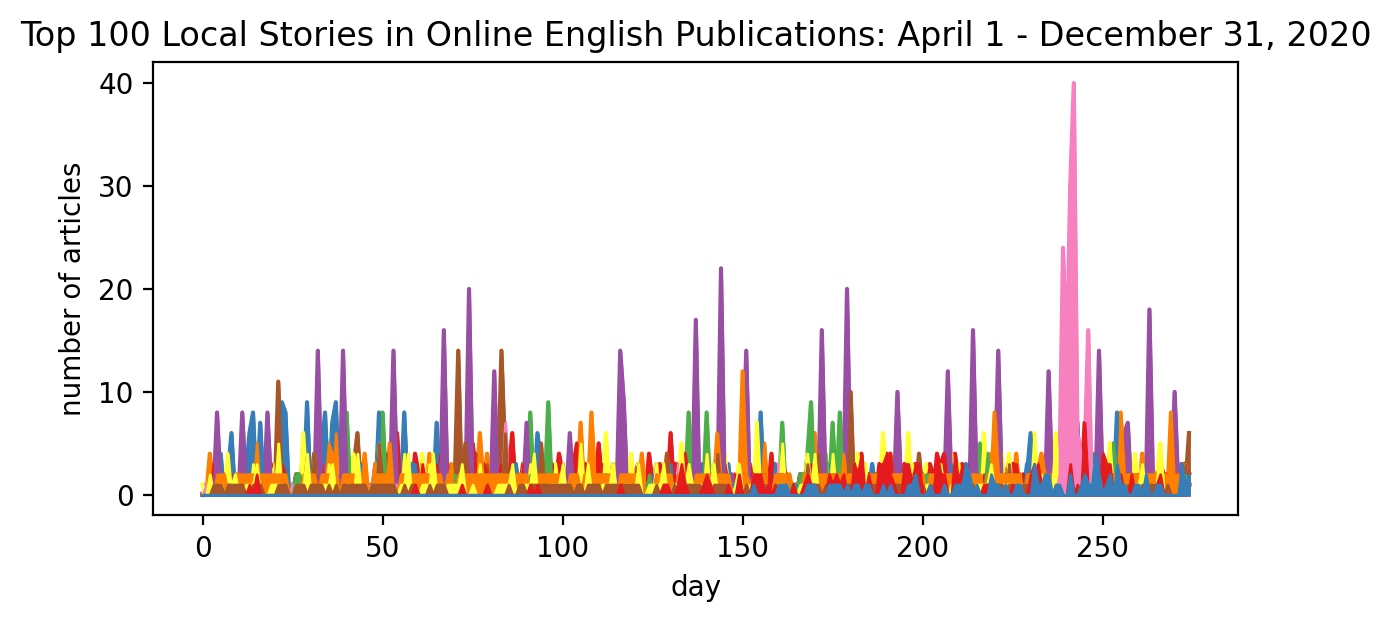

In [516]:
#look at only national stories 
plt.rcParams['figure.dpi'] = 200
localDf = clustDf[clustDf["nationalPercent"] == 0]
topLocalStories = generateTopStories(localDf, 50, "clustSize")
localStories = plotTopStories(topLocalStories, "Local")

In [342]:
#localStories

In [341]:
#list(df.loc[df["clustNum"] == 59231.0, "source"])

In [518]:
#now look at local stories in terms of tallest spikes 
clustDf["topDayInt"] = clustDf["dateInt"].apply(lambda x: Counter(x).most_common()[0][0])
clustDf["spikeSize"] = clustDf["dateInt"].apply(lambda x: Counter(x).most_common()[0][1])

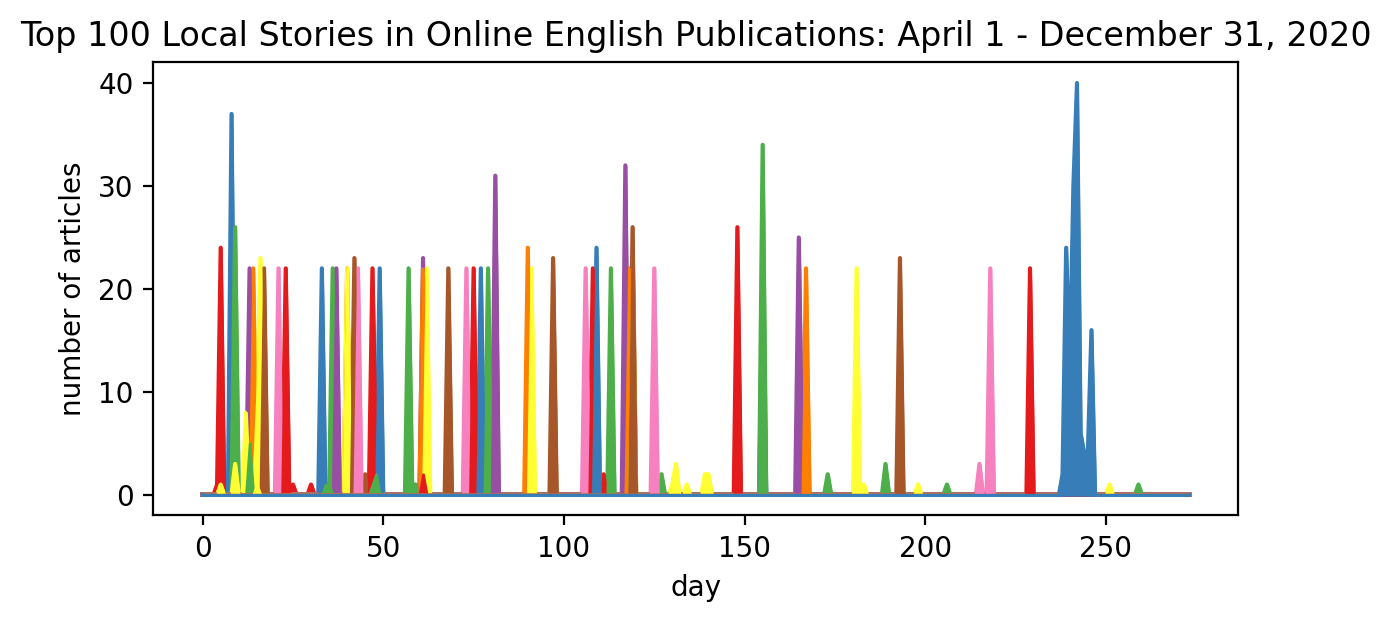

In [519]:
#look at only national stories 
plt.rcParams['figure.dpi'] = 200
localSpikesDf = clustDf[clustDf["nationalPercent"] == 0] #.sort_values("spikeSize", ascending=False)
topLocalSpikes = generateTopStories(localSpikesDf, 50, "spikeSize")
localSpikes = plotTopStories(topLocalSpikes, "Local")

In [534]:
def plotTopStoriesState(topStoriesDaily, storyType, storyNum, title=None): 
    outTups = []
    fig, axs = plt.subplots(figsize=(7, 3))
    palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
    for i, clustNum in enumerate(topStoriesDaily.sort_values("topDay", ascending=True)["clustNum"].unique()): 
        currColor = palette[i % len(palette)]
        
        #get a particular set of stories (in df form)
        currStories = topStoriesDaily[topStoriesDaily["clustNum"] == clustNum] #.drop(columns=["key"])

        #get the day ints that we need to fill in
        lastDay = max(df["dateInt"])
        missingDays = set(range(0, int(lastDay))) - set(currStories["dateInt"].unique())

        #a dataframe to fill in missing days with 0 stories 
        topDay = list(currStories["topDay"])[0]
        
        topDay = list(currStories["topDay"])[0]
        missingDaysDf = pd.DataFrame({"clustNum":clustNum, "dateInt":list(missingDays), "key":0, "topDay":topDay, "state":0, "lat":0, "lon":0})
        currStories = pd.concat([currStories, missingDaysDf], axis=0).sort_values("dateInt")
        
        
        plt.plot(currStories["dateInt"], currStories["state"], color=currColor)
        #seaborn version: (same) plot = sns.lineplot(x="dateInt",y="key",data=currStories, alpha=1)
        plt.fill_between(currStories.dateInt.values, currStories.state.values, zorder=i, color=currColor)
        outTups.append((clustNum, currColor, topDay))
    if title == None: 
        plt.title(f"State-Level Spread of Top {storyNum} {storyType} Stories in Online English Publications: April 1 - December 31, 2020", fontsize=7)
    else: 
        plt.title(title, fontsize=7)
    plt.xlabel("day")
    plt.ylabel("number of states")
    plt.ylim(0, 30)
    return outTups 

In [452]:
stateClusts = generateStateClusts(clustDf, 50, "clustSize")

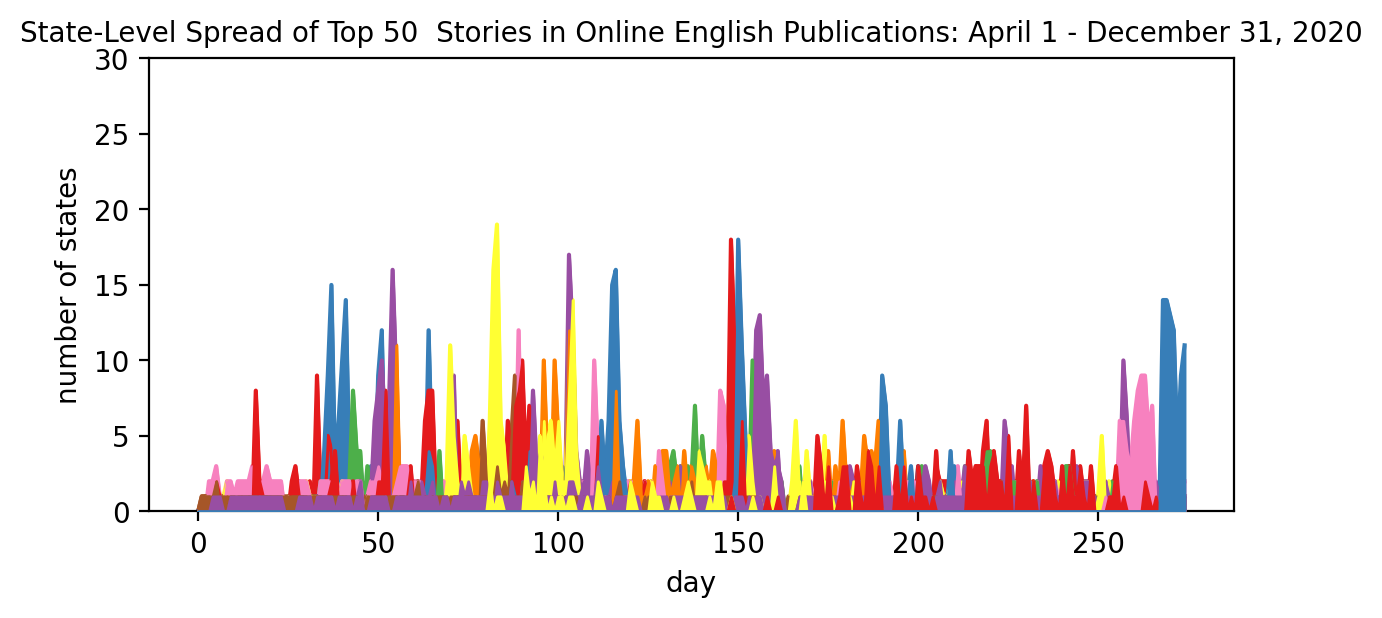

In [507]:
stateStories = plotTopStoriesState(stateClusts, "", 50)

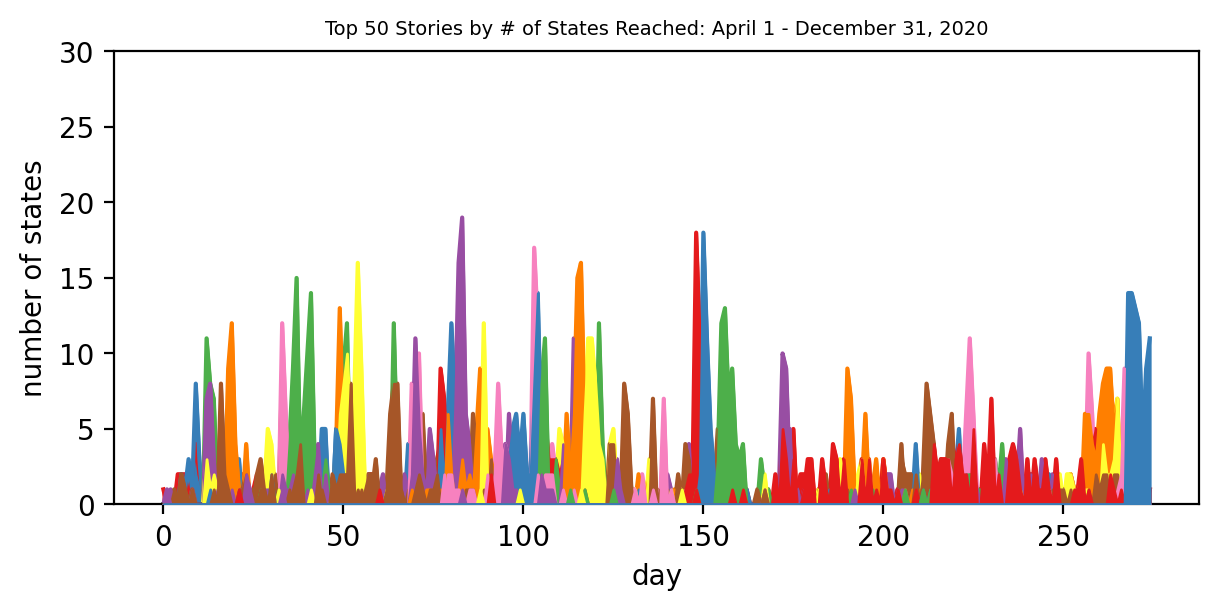

In [535]:
topStateStories = generateTopStories(clustDf, 50, "numStates").sort_values("state", ascending=False)
topStateClusts = plotTopStoriesState(topStateStories, "", 50, "Top 50 Stories by # of States Reached: April 1 - December 31, 2020")

In [529]:
topStateClusts

[(32360.0, '#e41a1c', 9.0),
 (32772.0, '#377eb8', 9.0),
 (16287.0, '#4daf4a', 12.0),
 (2804.0, '#984ea3', 12.0),
 (24182.0, '#ff7f00', 19.0),
 (3113.0, '#ffff33', 29.0),
 (6924.0, '#a65628', 33.0),
 (493.0, '#f781bf', 33.0),
 (20335.0, '#e41a1c', 35.0),
 (9078.0, '#377eb8', 36.0),
 (19927.0, '#4daf4a', 37.0),
 (8473.0, '#984ea3', 43.0),
 (5538.0, '#ff7f00', 49.0),
 (397.0, '#ffff33', 54.0),
 (4839.0, '#a65628', 64.0),
 (15207.0, '#f781bf', 70.0),
 (2378.0, '#e41a1c', 77.0),
 (1950.0, '#377eb8', 80.0),
 (15862.0, '#4daf4a', 83.0),
 (29.0, '#984ea3', 83.0),
 (1008.0, '#ff7f00', 88.0),
 (12298.0, '#ffff33', 89.0),
 (8491.0, '#a65628', 98.0),
 (688.0, '#f781bf', 103.0),
 (10803.0, '#e41a1c', 104.0),
 (2297.0, '#377eb8', 104.0),
 (22282.0, '#4daf4a', 106.0),
 (32819.0, '#984ea3', 114.0),
 (1337.0, '#ff7f00', 115.0),
 (21839.0, '#ffff33', 117.0),
 (6514.0, '#a65628', 128.0),
 (17442.0, '#f781bf', 139.0),
 (241.0, '#e41a1c', 148.0),
 (819.0, '#377eb8', 150.0),
 (1763.0, '#4daf4a', 155.0),
 (6